# Identify patterns that affect game sales

For an online store that sells computer games around the world, it is necessary, based on historical data from open sources on game sales, user and expert ratings, genres and platforms, to identify patterns that determine the success of the game. This will allow to bid on a potentially popular product and plan advertising campaigns.

## Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

In [2]:
data = pd.read_csv('/content/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.columns = data.columns.str.lower()

In [6]:
data.duplicated().sum()

0

Data.info() shows that there are no titles for two games. Let's find them:

In [7]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


As you can see, these are old games, their consideration does not make sense, let's get rid of these entries:

In [8]:
data = data.dropna(subset=['name']).reset_index(drop=True)

To predict sales for the next year, it makes sense to consider games on the platforms of the current and, possibly, the previous generation as games for some time continue to be released simultaneously on the platforms of two generations. Let's define the platforms of the current generation by the first appearance of games on them:

In [9]:
data.groupby('platform')['year_of_release'].min().sort_values(ascending=False)

platform
XOne    2013.0
PS4     2013.0
WiiU    2012.0
3DS     2011.0
PSV     2011.0
PS3     2006.0
Wii     2006.0
X360    2005.0
PSP     2004.0
GC      2001.0
GBA     2000.0
PS2     2000.0
XB      2000.0
WS      1999.0
DC      1998.0
PCFX    1996.0
N64     1996.0
TG16    1995.0
SAT     1994.0
PS      1994.0
3DO     1994.0
SCD     1993.0
NG      1993.0
GG      1992.0
SNES    1990.0
GEN     1990.0
GB      1988.0
PC      1985.0
DS      1985.0
NES     1983.0
2600    1980.0
Name: year_of_release, dtype: float64

In the list received, the first mention of the DS platform (Nintendo DS) is 1985, but this platform was introduced in the middle of the 2000s. Let's check what led to this:

In [10]:
data.query('platform == "DS"')['year_of_release'].value_counts()

2008.0    492
2009.0    403
2007.0    376
2010.0    323
2006.0    201
2011.0    153
2005.0    118
2004.0     23
2012.0     23
2013.0      8
1985.0      1
Name: year_of_release, dtype: int64

In [11]:
data.query('platform == "DS" & year_of_release == 1985')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15955,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN


One entry outlies. As this is a game with modest sales and only for the Japanese market, we will delete this entry.

In [12]:
data = data.drop(data.index[15955])

In [13]:
data.groupby('platform')['year_of_release'].min().sort_values(ascending=False)

platform
XOne    2013.0
PS4     2013.0
WiiU    2012.0
3DS     2011.0
PSV     2011.0
PS3     2006.0
Wii     2006.0
X360    2005.0
PSP     2004.0
DS      2004.0
GC      2001.0
GBA     2000.0
XB      2000.0
PS2     2000.0
WS      1999.0
DC      1998.0
PCFX    1996.0
N64     1996.0
TG16    1995.0
SAT     1994.0
PS      1994.0
3DO     1994.0
SCD     1993.0
NG      1993.0
GG      1992.0
SNES    1990.0
GEN     1990.0
GB      1988.0
PC      1985.0
NES     1983.0
2600    1980.0
Name: year_of_release, dtype: float64

Now the chronology of platforms entering the market has been restored.

Now let's look at the years of the last releases:

In [14]:
data.groupby('platform')['year_of_release'].max().sort_values(ascending=False).head(15)

platform
XOne    2016.0
3DS     2016.0
X360    2016.0
WiiU    2016.0
Wii     2016.0
PSV     2016.0
PC      2016.0
PS4     2016.0
PS3     2016.0
PSP     2015.0
DS      2013.0
PS2     2011.0
DC      2008.0
XB      2008.0
GBA     2007.0
Name: year_of_release, dtype: float64

As a result, the current console platforms were determined: XOne, PS4, WiiU, 3DS and PSV, as well as past generation consoles: X360, Wii, PS3. Also, PC is always actual gaming platform.

In [15]:
data.query(
    'platform == ["PSV","XOne","PS4","WiiU","3DS","PC","X360","Wii","PS3"]').groupby('platform')['name'].count()

platform
3DS      520
PC       974
PS3     1331
PS4      392
PSV      430
Wii     1320
WiiU     147
X360    1262
XOne     247
Name: name, dtype: int64

Let's determine the number of NaNs by the year the game was released relative to the platform on which it was released:

In [16]:
data[data['year_of_release'].isna()].groupby('platform')['name'].count()

platform
2600    17
3DS      8
DS      30
GB       1
GBA     11
GC      14
N64      3
PC      17
PS       7
PS2     34
PS3     25
PSP     16
PSV      1
Wii     34
X360    30
XB      21
Name: name, dtype: int64

Missing release years are not present in the current generation of consoles, present at about 2% for each of the considered past generation consoles and PC. With such a small number of missing values, this data can be discarded.

In [17]:
data = data.dropna(subset=['year_of_release']).reset_index(drop=True)

In [18]:
data['year_of_release'] = data['year_of_release'].astype(int)

Let's add the value of the total sales of games in all regions to the table:

In [19]:
data['sales_total'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
#data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [20]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Let's check what values are found in the rating column:

In [21]:
data.rating.value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Missing values in the "critic_score", "user_score", "rating" columns may mean that there really is no information about these games, or a technical error occurred during data collection. It is not advisable to fill in these gaps with any calculated values based on the rest of the available data, since even the same game on different platforms can have significantly different ratings, both user and critic.

In [22]:
data.rating = data.rating.fillna('unknown')

For some games, the value of the user rating is TBD (to be determined), which means that the rating is not currently calculated, the reason for this may be, for example, a small number of ratings from users. For further work with the data of this column, we will technically replace this value with "-1" and change the data type to float.

In [23]:
data['user_score'] = np.where(data['user_score']=='tbd',-1,data['user_score'])
data['user_score'] = data['user_score'].astype('float')

## EDA

### Estimation of the number of released games per year for the entire observation period

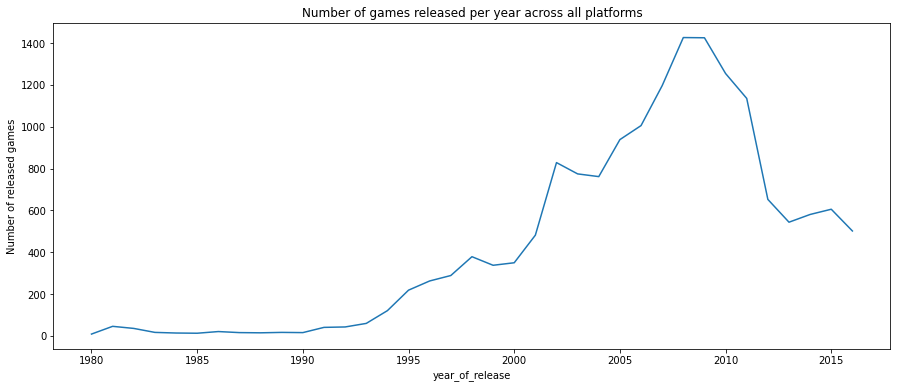

In [24]:
plt.title('Number of games released per year across all platforms')
plt.xlabel('Year')
plt.ylabel('Number of released games')
data.groupby('year_of_release')['name'].count().plot(figsize=(15,6))
plt.show()

The graph shows the development of the gaming industry from 1980 to the present. It can be seen that the beginning of a steady growth in the production of computer games falls on the mid-90s - the time when the Sony PlayStation (PS) console appeared. The maximum figures for the number of released games correspond to the period from 2005 to 2013 - the time of the relevance of the previous generation of gaming platforms (PS3, X360, Wii).

### Estimating sales of games across platforms

Let's see how sales have changed by platform, for this we will select the TOP-10 platforms by the number of games sold:

In [25]:
top_10_platforms = data.groupby('platform', as_index=False)[['sales_total']].sum(
).sort_values(by='sales_total', ascending=False).head(10)

In [26]:
top_10_platforms

,platform,sales_total
16,PS2,1233.56
28,X360,961.24
17,PS3,931.34
26,Wii,891.18
4,DS,802.76
15,PS,727.58
18,PS4,314.14
6,GBA,312.88
19,PSP,289.53
2,3DS,257.81


Let's build the distribution by year of the total sales of the previously selected platforms:

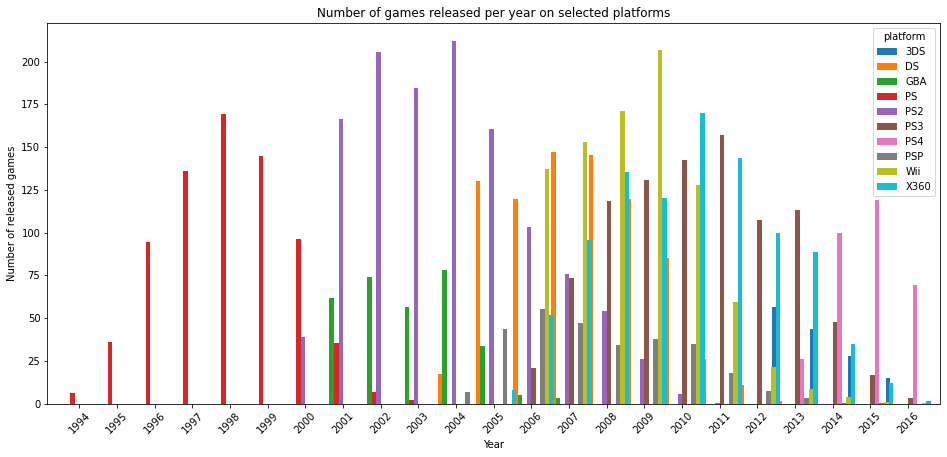

In [27]:
data.query('platform in @top_10_platforms.platform'
          ).pivot_table(index='year_of_release', columns='platform', values='sales_total', aggfunc='sum'
                       ).plot(figsize=(16,7), kind='bar', width=1.2, rot=45)
plt.title('Number of games released per year on selected platforms')
plt.xlabel('Year')
plt.ylabel('Number of released games')
plt.show()

On the graph, the life cycle of the platform is displayed along the horizontal axis. It averages 10 years, with a peak in the middle of this period. It is also clear that with the advent of the next generation of the platform, the previous one remains relevant for some time. Let's look at this using the PlayStation and Xbox generations as an example:

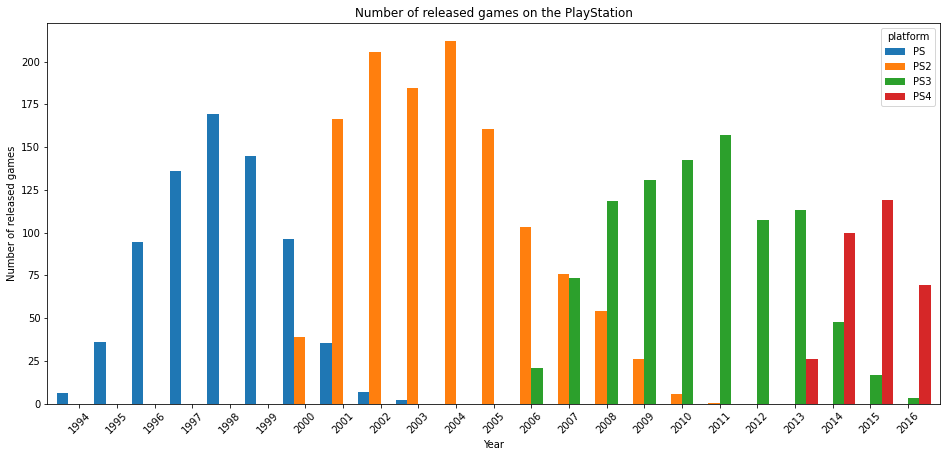

In [28]:
data.query('platform == ["PS", "PS2", "PS3", "PS4"]'
          ).pivot_table(index='year_of_release', columns='platform', values='sales_total', aggfunc='sum'
                       ).plot(figsize=(16,7), kind='bar', width=1.2, rot=45)
plt.title('Number of released games on the PlayStation')
plt.xlabel('Year')
plt.ylabel('Number of released games')
plt.show()

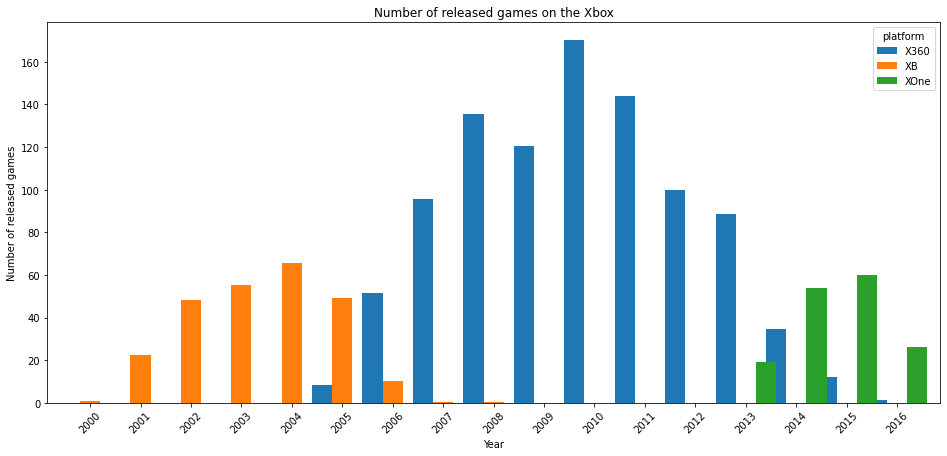

In [29]:
data.query('platform == ["XB", "X360", "XOne"]'
          ).pivot_table(index='year_of_release', columns='platform', values='sales_total', aggfunc='sum'
                       ).plot(figsize=(16,7), kind='bar', width=1.2, rot=45)
plt.title('Number of released games on the Xbox')
plt.xlabel('Year')
plt.ylabel('Number of released games')
plt.show()

The examples above show that although the previous generation of consoles continues to remain on the market for the first time after the release of new devices, but its share is so small that it cannot be used to predict sales for the future period. In other words, you should concentrate on studying the market for gaming platforms of the current generation.

Let's make a list of relevant gaming platforms for forecasting for 2017:

In [30]:
actual_platforms = data.groupby('platform')['year_of_release'].min(
).sort_values(ascending=False).head(5).reset_index()['platform']
actual_platforms[len(actual_platforms)] = 'PC'
actual_platforms

0    XOne
1     PS4
2    WiiU
3     3DS
4     PSV
5      PC
Name: platform, dtype: object

Let's determine which platforms are leading in sales. Because the description of the dataset says that the data for 2016 may not be complete, we will not take them into account when determining. Data for the years preceding the emergence of the platforms under consideration are also not considered.

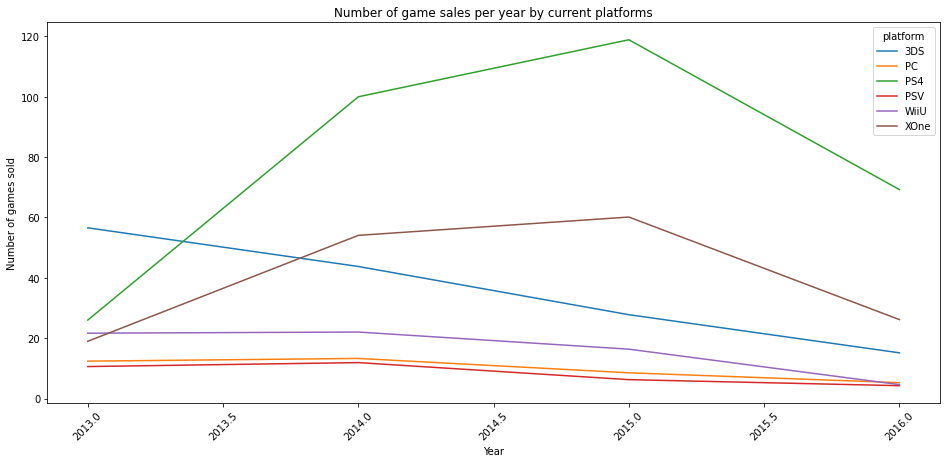

In [31]:
data.query('platform in @actual_platforms & 2013 <= year_of_release'
          ).pivot_table(index='year_of_release', columns='platform', values='sales_total', aggfunc='sum'
                       ).plot(figsize=(16,7), rot=45)
plt.title('Number of game sales per year by current platforms')
plt.xlabel('Year')
plt.ylabel('Number of games sold')
plt.show()

The graph shows that the PS4 and XOne platforms can become potentially profitable in 2017, demonstrating stable sales growth over the past periods.

Let's make a box-and-mustache plot of global game sales by platform:

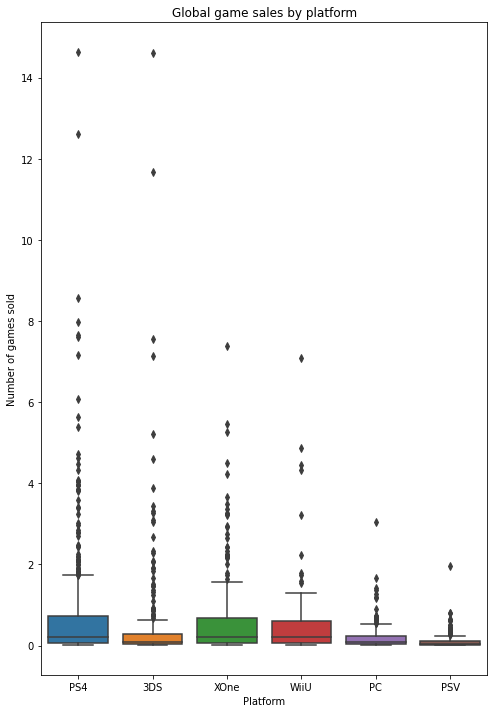

In [32]:
plt.subplots(figsize=(8,12))
sns.boxplot(x=data.query('platform in @actual_platforms & 2013 <= year_of_release'
          )['platform'], y=data.query('platform in @actual_platforms & 2013 <= year_of_release'
          )['sales_total'])
plt.title('Global game sales by platform')
plt.xlabel('Platform')
plt.ylabel('Number of games sold')
plt.show()

There are too large upshoots, we will limit the scale of the number of sales to improve the visibility of the charts:

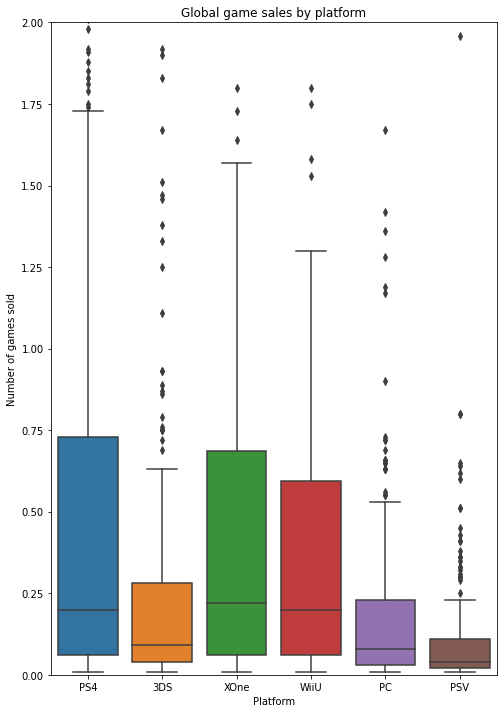

In [33]:
plt.subplots(figsize=(8,12))
plt.ylim(0,2)
sns.boxplot(x=data.query('platform in @actual_platforms & 2013 <= year_of_release'
          )['platform'], y=data.query('platform in @actual_platforms & 2013 <= year_of_release'
          )['sales_total'])
plt.title('Global game sales by platform')
plt.xlabel('Platform')
plt.ylabel('Number of games sold')
plt.show()

The distributions of circulation of games sold within the platforms under consideration (PS4 and XOne) are similar, and the distribution of WiiU roughly corresponds to them (but the total sales of games for this platform do not allow us to consider it as potentially profitable). Their parameters Q1, Q2 are approximately equal, and Q3 differ not so significantly as in other platforms. Most of the games in the period under review on all platforms are sold with circulations not exceeding 750,000 copies, but there are also titles with outstanding sales of several million copies on all platforms.

### Evaluation of the impact of reviews on the level of sales of games on the PS4 and XOne platforms

Let's see how the reviews of users and critics affect sales within the platform:

In [34]:
xone_data = data.query('platform == "XOne"')

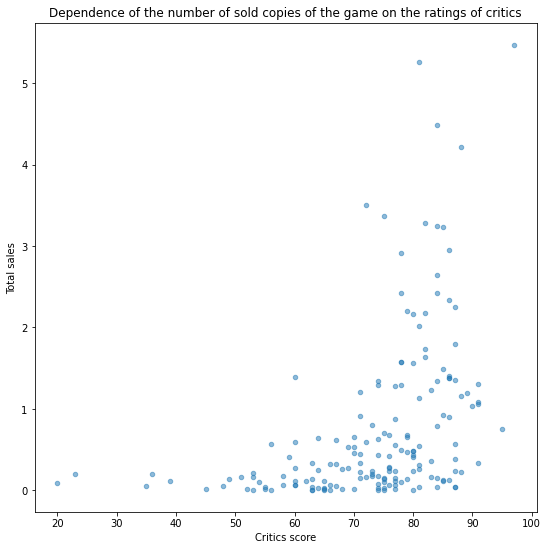

In [35]:
xone_data[~xone_data['critic_score'].isna()].plot(
    x='critic_score', y='sales_total', kind='scatter', alpha=0.5, figsize=(9,9))
plt.title('Dependence of the number of sold copies of the game on the ratings of critics')
plt.xlabel('Critics score')
plt.ylabel('Total sales')
plt.show()

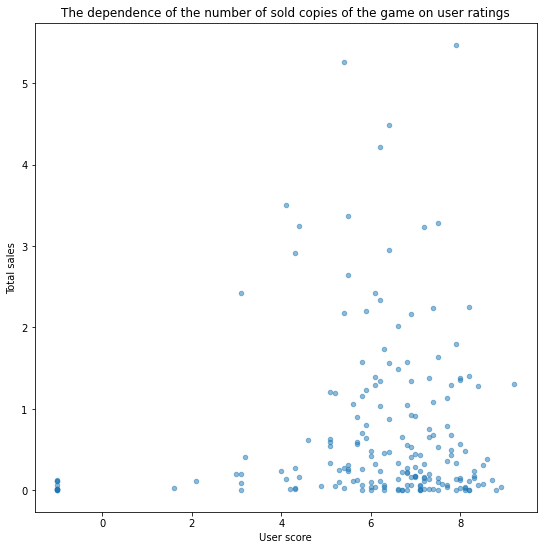

In [36]:
xone_data[~xone_data['user_score'].isna() & xone_data['user_score'] != -1].plot(
    x='user_score', y='sales_total', kind='scatter', alpha=0.5, figsize=(9,9))
plt.title('The dependence of the number of sold copies of the game on user ratings')
plt.xlabel('User score')
plt.ylabel('Total sales')
plt.show()

Correlation of total sales and critics' ratings:

In [37]:
xone_data[~xone_data['critic_score'].isna()]['critic_score'].corr(
    xone_data[~xone_data['critic_score'].isna()]['sales_total'])

0.4169983280084017

Correlation of total sales and player ratings:

In [38]:
xone_data[~xone_data['user_score'].isna() & xone_data['user_score'] != -1]['user_score'].corr(
    xone_data[~xone_data['user_score'].isna() & xone_data['user_score'] != -1]['sales_total'])

0.08525772912713797

In [39]:
ps4_data = data.query('platform == "PS4"')

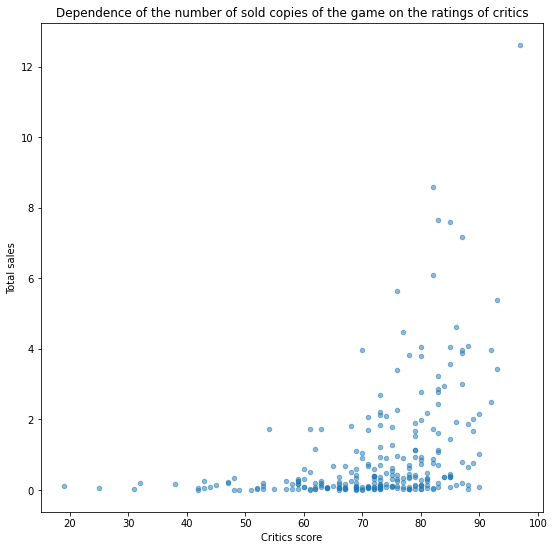

In [40]:
ps4_data[~ps4_data['critic_score'].isna()].plot(
    x='critic_score', y='sales_total', kind='scatter', alpha=0.5, figsize=(9,9))
plt.title('Dependence of the number of sold copies of the game on the ratings of critics')
plt.xlabel('Critics score')
plt.ylabel('Total sales')
plt.show()

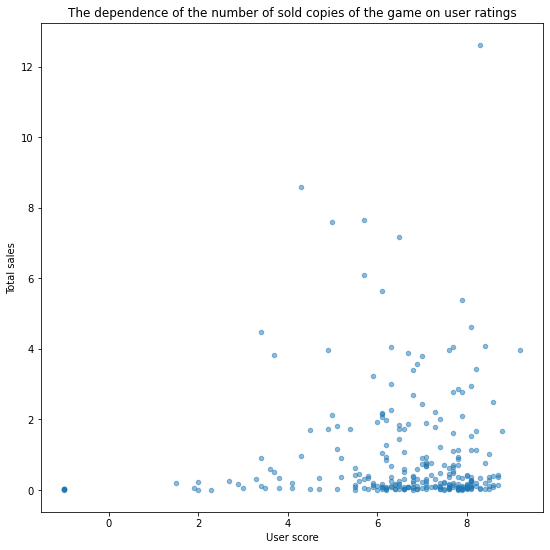

In [41]:
ps4_data[~ps4_data['user_score'].isna() & ps4_data['user_score'] != -1].plot(
    x='user_score', y='sales_total', kind='scatter', alpha=0.5, figsize=(9,9))
plt.title('The dependence of the number of sold copies of the game on user ratings')
plt.xlabel('User score')
plt.ylabel('Total sales')
plt.show()

In [42]:
ps4_data[~ps4_data['critic_score'].isna()]['critic_score'].corr(
    ps4_data[~ps4_data['critic_score'].isna()]['sales_total'])

0.40656790206178095

In [43]:
ps4_data[~ps4_data['user_score'].isna() & ps4_data['user_score'] != -1]['user_score'].corr(
    ps4_data[~ps4_data['user_score'].isna() & ps4_data['user_score'] != -1]['sales_total'])

0.029109559532921808

The graphs do not show any pronounced trends in the dependence of the number of sales on reviews, at least they cannot be used to state that there is a linear relationship between these parameters. This is also confirmed by the calculated correlation coefficients, with values around 0.4 for both platforms.

### Definition of popular game genres

Let's build a graph of the distribution of the number of sales of games of different genres:

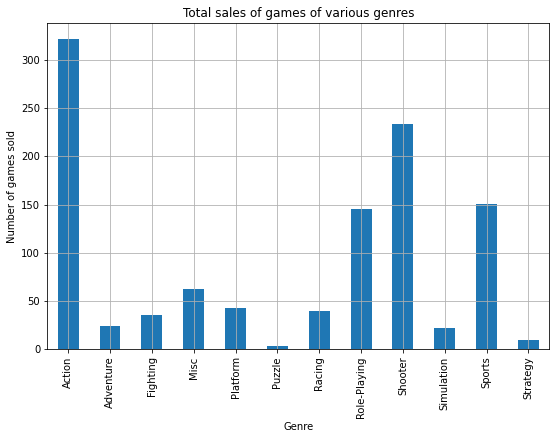

In [44]:
data.query('year_of_release >= 2013').groupby('genre')['sales_total'].sum().plot(kind='bar', figsize=(9,6), grid=True)
plt.title('Total sales of games of various genres')
plt.xlabel('Genre')
plt.ylabel('Number of games sold')
plt.show()

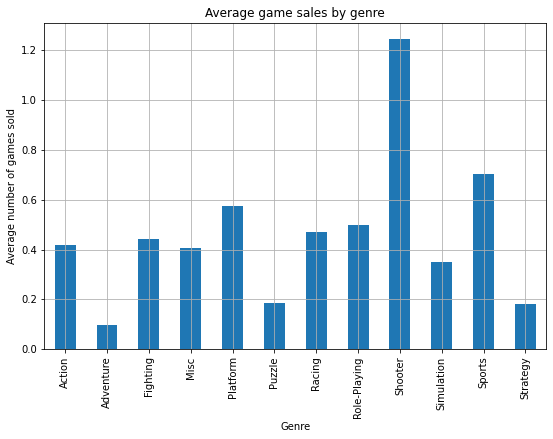

In [45]:
data.query('year_of_release >= 2013'
          ).groupby('genre')['sales_total'].mean().plot(kind='bar', figsize=(9,6), grid=True)
plt.title('Average game sales by genre')
plt.xlabel('Genre')
plt.ylabel('Average number of games sold')
plt.show()

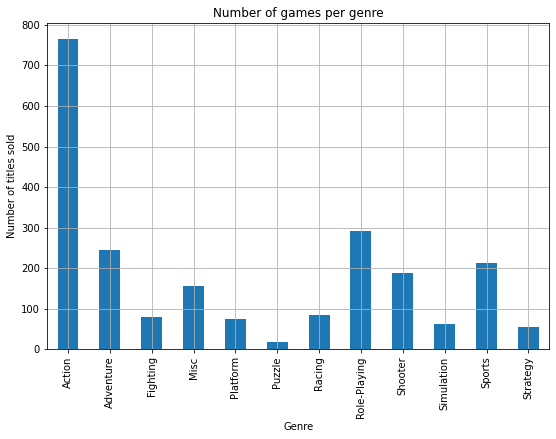

In [46]:
data.query('year_of_release >= 2013'
          ).groupby('genre')['sales_total'].count().plot(kind='bar', figsize=(9,6), grid=True)
plt.title('Number of games per genre')
plt.xlabel('Genre')
plt.ylabel('Number of titles sold')
plt.show()

Average sales of games are conditionally divided into three groups, in which shooters and sports games are in the lead, adventures, puzzles and strategies are the least bought. The rest of the genres are sold almost equally. At the same time, the number of released games of the action genre significantly exceeds the number of games of all other genres. We conclude that in total sales, the action genre is dominated by quantity, and shooters - by quality.

## Drawing up a portrait of the user of each region

When comparing the preferred gaming platforms by users from different regions, it makes sense to make a comparison relative to the current gaming era, from 2013 to the present, we will consider the genre preferences of users for the entire observation period.

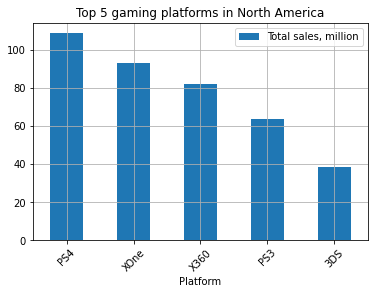

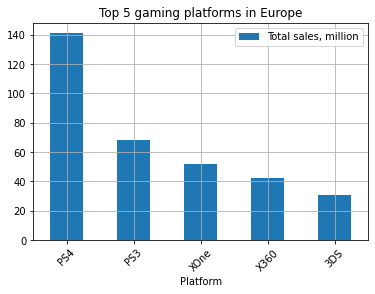

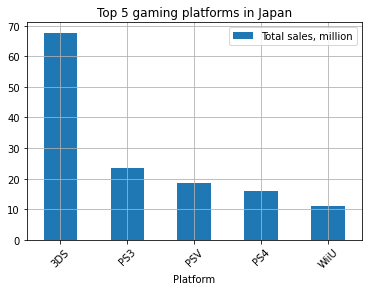

In [47]:
data.query('na_sales > 0 & year_of_release >= 2013'
          ).pivot_table(index='platform', values=['na_sales'], aggfunc=['sum']
).sort_values(by=('sum','na_sales'), ascending=False).head().plot(kind='bar', grid=True, rot=45)
plt.title('Top 5 gaming platforms in North America')
plt.legend(['Total sales, million'])
plt.xlabel('Platform')
data.query('eu_sales > 0 & year_of_release >= 2013'
          ).pivot_table(index='platform', values=['eu_sales'], aggfunc=['sum']
).sort_values(by=('sum','eu_sales'), ascending=False).head().plot(kind='bar', grid=True, rot=45)
plt.title('Top 5 gaming platforms in Europe')
plt.legend(['Total sales, million'])
plt.xlabel('Platform')
data.query('jp_sales > 0 & year_of_release >= 2013'
          ).pivot_table(index='platform', values=['jp_sales'], aggfunc=['sum']
).sort_values(by=('sum','jp_sales'), ascending=False).head().plot(kind='bar', grid=True, rot=45)
plt.title('Top 5 gaming platforms in Japan')
plt.legend(['Total sales, million'])
plt.xlabel('Platform')
plt.show()

The comparison shows that the PS4 leads the North American and European markets. The total share of Playstation (PS4 and PS3) in the European market is almost half of all popular platforms, while in America the market is divided approximately in half between Xbox (XOne and X360) and Playstation. The Japanese market lives by its own laws, most of all game sales come from a portable console from Nintendo.

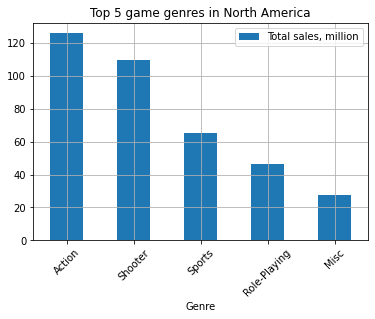

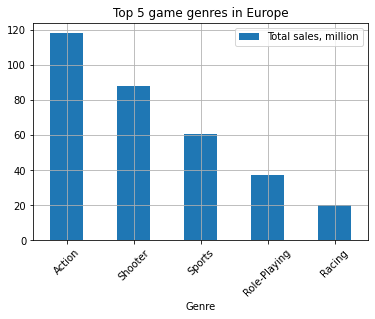

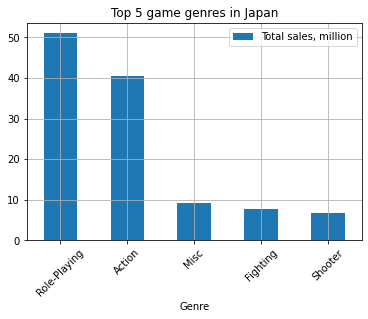

In [48]:
data.query('na_sales > 0 & year_of_release >= 2013').pivot_table(index='genre', values=['na_sales'], aggfunc=['sum']
).sort_values(by=('sum','na_sales'), ascending=False).head().plot(kind='bar', grid=True, rot=45)
plt.title('Top 5 game genres in North America')
plt.legend(['Total sales, million'])
plt.xlabel('Genre')
data.query('eu_sales > 0 & year_of_release >= 2013').pivot_table(index='genre', values=['eu_sales'], aggfunc=['sum']
).sort_values(by=('sum','eu_sales'), ascending=False).head().plot(kind='bar', grid=True, rot=45)
plt.title('Top 5 game genres in Europe')
plt.legend(['Total sales, million'])
plt.xlabel('Genre')
data.query('jp_sales > 0 & year_of_release >= 2013').pivot_table(index='genre', values=['jp_sales'], aggfunc=['sum']
).sort_values(by=('sum','jp_sales'), ascending=False).head().plot(kind='bar', grid=True, rot=45)
plt.title('Top 5 game genres in Japan')
plt.legend(['Total sales, million'])
plt.xlabel('Genre')
plt.show()

The distribution proportions by genre are similar in America and Europe, the only difference is that in Europe the Racing genre is the fifth most popular genre, instead of RPG in America. In the Japanese market, Role-Playing and Action are the most popular genres, other genres lag behind them in popularity by several times.

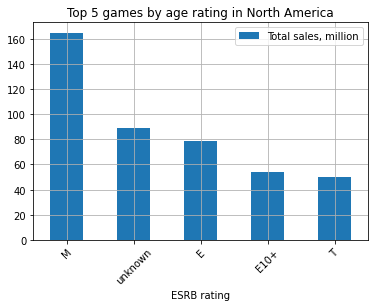

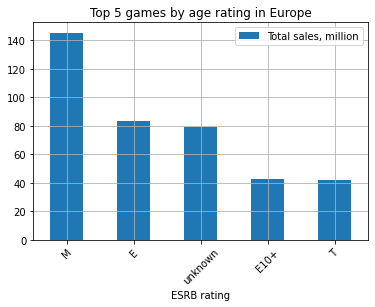

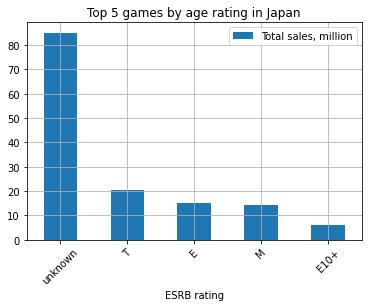

In [49]:
data.query('na_sales > 0 & year_of_release >= 2013').pivot_table(index='rating', values='na_sales', aggfunc=['sum']
).sort_values(by=('sum', 'na_sales'), ascending=False).plot(kind='bar', grid=True, rot=45)
plt.legend(['Total sales, million'])
plt.xlabel('ESRB rating')
plt.title('Top 5 games by age rating in North America')
data.query('eu_sales > 0 & year_of_release >= 2013').pivot_table(index='rating', values='eu_sales', aggfunc=['sum']
).sort_values(by=('sum', 'eu_sales'), ascending=False).plot(kind='bar', grid=True, rot=45)
plt.legend(['Total sales, million'])
plt.xlabel('ESRB rating')
plt.title('Top 5 games by age rating in Europe')
data.query('jp_sales > 0 & year_of_release >= 2013').pivot_table(index='rating', values='jp_sales', aggfunc=['sum']
).sort_values(by=('sum', 'jp_sales'), ascending=False).plot(kind='bar', grid=True, rot=45)
plt.title('Top 5 games by age rating in Japan')
plt.legend(['Total sales, million'])
plt.xlabel('ESRB rating')
plt.show()

In all regions there is no fundamental difference in the distribution of the age rating of popular games. Everywhere from known the rating of Mature is in the lead. Teens, Everyone and unknown, as well as E10+ and Teens have similar shares in Europe and America. Japan, by tradition, demonstrates a different distribution by age ratings, but the positions in it are the same as on other continents.

## Conclusion

Based on the study, the following conclusions were made:
* The most promising in 2017 will be to bet on the sale of games for the PS4 and Xbox One platforms.
* Most sales can be expected for Action, Sports, Shooter, RPG games.
* User ratings and critic reviews do not significantly affect the level of sales of games, because. they are not always objective.
* Most games sold in Europe and America are rated Mature (17+). For a significant proportion of games, the rating is not defined.
* The lifetime of a platform generation reaches ten years (PC does not count, because there is continuous evolution), while the peak of platform popularity comes in the middle of its life cycle, which is happening right now (2017) for recommended earlier platforms.
* In general, the gaming industry of large platforms is currently going through hard times compared to the period of relevance of the previous generation, this is largely due to the development of mobile gaming, and the transition of a part of the audience to this entertainment segment.